#GMM

In [ ]:
#Modules Imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Gaussian Mixture Model Clustering
def GMM(Data,Q,Class,ax1,ax2,tol=1e-3,itr=1e2):
    N = Data.shape[0] #No of data points
    d = Data.shape[1] #Dimension of data
    #Initializing
    Pi  = np.ones(Q)/Q     #Weight/Prior of Gaussian
    u   = np.zeros((Q,d))  #Mean of Gaussian
    Cov = np.zeros((Q,d,d))#Covariance of Gaussian
    #Initializing Clusters using Random Partition Method
    Cluster = np.random.randint(0,Q,N)

    for k in range(Q):
        u[k]  = Data[Cluster==k].mean(axis=0)
        Cov[k]= np.cov(Data[Cluster==k].T)

    r = np.zeros((N,Q)) #Responsibility
    #log likelihood
    log_likelihood_prev = -10**100
    log_likelihood      = -9**100

    while(itr and abs(log_likelihood-log_likelihood_prev)>tol):
        #E-step
        for k in range(Q):
            Cov_det = np.linalg.det(Cov[k])
            #Handling worst case
            if Cov_det<1e-10:
              Cov_det = 1e-10
              Cov_inv = np.eye(d)
            else:
              Cov_inv = np.linalg.inv(Cov[k])
            #print(Cov_det)
            for i in range(N):
                r[i][k] = Pi[k]* (2*np.pi)**(-0.5*d)*Cov_det**(-0.5) *np.exp(-0.5*(Data[i]-u[k])@Cov_inv@(Data[i]-u[k]).T)

        log_likelihood_prev = log_likelihood
        log_likelihood = sum(np.log((1e-50+r).sum(axis=1)))
        for i in range(N):
            r[i] /= sum(r[i])

        #M-step
        u   *=0
        Cov *=0
        for k in range(Q):
            Nk = sum(r[:,k])
            Pi[k] = Nk/N
            for i in range(N):
                u[k]   += 1/Nk * r[i][k] * Data[i]
            for i in range(N):
                Cov[k] += 1/Nk * r[i][k] * np.outer((Data[i]-u[k]),(Data[i]-u[k]).T)
        itr-=1

    #Assigning Cluster based on Responsibility
    Cluster = r.argmax(axis=1)

    #Plot
    for k in range(Q):
        ax[ax1][ax2].scatter(Data[Cluster==k][:,0],Data[Cluster==k][:,1],alpha=1/3,
                    marker='.',label ='C='+str(Class)+' K='+str(k+1))
    return Pi,u,Cov,log_likelihood


In [ ]:
def Bayes_Classifier(Data,Q,ax1,ax2):
    print('*'*37,'Q = ',Q,'*'*37)
    #Test-Train Split
    np.random.shuffle(Data)
    f = 0.7

    # Train and test data
    train,test = Data[:int(f*Data.shape[0])],Data[int(f*Data.shape[0]):]

    C1 = train[train[:,-1]==1][:,:-1]
    C2 = train[train[:,-1]==2][:,:-1]

    # Apply GMM on each class
    Pi1,u1,Cov1,log_lh1 = GMM(C1, Q, 1,ax1,ax2) #GMM on C1
    Pi2,u2,Cov2,log_lh2 = GMM(C2, Q, 2,ax1,ax2) #GMM on C2
    log_likelihood = log_lh1+log_lh2            #Total log likelihood

    ax[ax1][ax2].set_title('Q = '+str(Q))
    ax[ax1][ax2].legend(fontsize=6)
    ax[ax1][ax2].set_xlabel('Attribute 1')
    ax[ax1][ax2].set_ylabel('Attribute 2')
    ax[ax1][ax2].grid()

    #Prior
    Prior_C1 = len(C1)/len(train)
    Prior_C2 = len(C2)/len(train)

    y = test[:,-1]
    Prediction = y*0

    d = test.shape[1]-1
    Cov_det1 = np.zeros(Q)
    Cov_det2 = np.zeros(Q)
    Cov_inv1 = np.zeros((Q,d,d))
    Cov_inv2 = np.zeros((Q,d,d))
    for k in range(Q):
        Cov_det1[k] = np.linalg.det(Cov1[k])
        Cov_det2[k] = np.linalg.det(Cov2[k])

        Cov_inv1[k] = np.linalg.inv(Cov1[k])
        Cov_inv2[k] = np.linalg.inv(Cov2[k])

    #Bayes Classification
    for i in range(len(test)):
        P_C1 = 0;P_C2 = 0
        for k in range(Q):
            #Posterior Probability = Likelihood*Prior/Evidance
            #Likelihood => Linear Superposition of Q Gaussian Components
            P_C1 += Prior_C1 * Pi1[k]* (2*np.pi)**(-0.5*d)*Cov_det1[k]**(-0.5) *np.exp(-0.5*(test[i][:-1]-u1[k])@Cov_inv1[k]@(test[i][:-1]-u1[k]).T)
            P_C2 += Prior_C2 * Pi2[k]* (2*np.pi)**(-0.5*d)*Cov_det2[k]**(-0.5) *np.exp(-0.5*(test[i][:-1]-u2[k])@Cov_inv2[k]@(test[i][:-1]-u2[k]).T)
        p_x = P_C1+P_C2
        P_C1/=p_x;
        P_C2/=p_x
        # Bayes decision rule
        if P_C1>=P_C2:
          Prediction[i] = 1
        else:
          Prediction[i] = 2
    Confusion_Matrix = np.zeros((d,d))
    #Confusion Matrix
    for og_class in range(1,3):
        for pred_class in range(1,3):
            Confusion_Matrix[og_class-1][pred_class-1] = sum(y[Prediction==pred_class]==og_class)

    # Calculating the confusion matrix
    Confusion_Matrix = np.int64(Confusion_Matrix)
    Accuracy = 0
    Precision= 0
    Recall   = 0
    F1_score = 0
    for i in range(2):
        Accuracy += Confusion_Matrix[i][i]
        if sum(Confusion_Matrix[i]):
            Precision+= Confusion_Matrix[i][i]/sum(Confusion_Matrix[i])*sum(Confusion_Matrix[:,i])
        if sum(Confusion_Matrix[:,i]):
            Recall+=Confusion_Matrix[i][i]/sum(Confusion_Matrix[:,i])*sum(Confusion_Matrix[:,i])
    if Confusion_Matrix.sum():
        Accuracy /=Confusion_Matrix.sum()
        Precision/=Confusion_Matrix.sum()
        Recall   /=Confusion_Matrix.sum()
    try:F1_score = 2*(Precision*Recall)/(Precision+Recall)
    except:F1_score = 0

    print('Confusion Matrix:\n',Confusion_Matrix)
    print('Accuracy:\t',np.around(Accuracy,4))
    print('Precision:\t',np.around(Precision,4))
    print('Recall:\t\t',np.around(Recall,4))
    print('F1-Score:\t',np.around(F1_score,4))
    print('\n')
    return log_likelihood

#### Question 1

************************************* Q =  1 *************************************
Confusion Matrix:
 [[577  14]
 [ 12 597]]
Accuracy:	 0.9783
Precision:	 0.9783
Recall:		 0.9783
F1-Score:	 0.9783


************************************* Q =  2 *************************************
Confusion Matrix:
 [[616   0]
 [  0 584]]
Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-Score:	 1.0


************************************* Q =  3 *************************************
Confusion Matrix:
 [[612   0]
 [  0 588]]
Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-Score:	 1.0


************************************* Q =  4 *************************************
Confusion Matrix:
 [[585   0]
 [  0 615]]
Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-Score:	 1.0




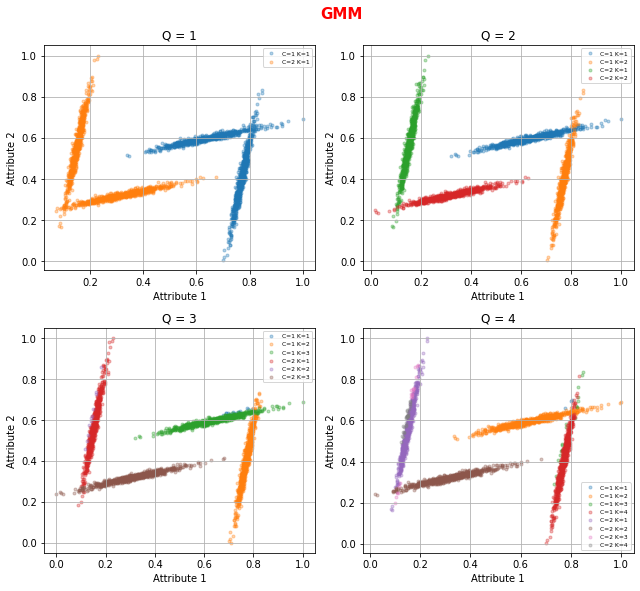

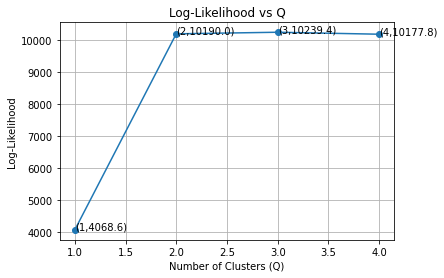

In [ ]:
#Data
C1 = pd.read_csv('Class1.txt',header=None)
C1['class'] = 1
C2 = pd.read_csv('Class2.txt',header=None)
C2['class'] = 2
Data = np.concatenate((C1,C2))
#Min-Max Normalization
Data[:,:2] = (Data[:,:2] - Data[:,:2].min(axis=0))/(Data[:,:2].max(axis=0) - Data[:,:2].min(axis=0))

#Bayes Classification on GMM
Q = [1,2,3,4];Log_Likelihood = []
a = 2;b = int(np.ceil(len(Q)/a))
fig,ax = plt.subplots(a,b,squeeze=False,figsize=(4.5*b,4*a))
fig.text(0.5,1,'GMM',color='Red',fontsize=15,fontweight='bold')
x,y = 0,0
for k in Q:
    log_likelihood = Bayes_Classifier(Data,Q=k,ax1=x,ax2=y)
    Log_Likelihood.append(log_likelihood)
    y+=1
    if y==b:x+=1;y=0
plt.tight_layout()
plt.show()

#Log-Likelihood vs Q
plt.plot(Q,Log_Likelihood,marker='o')
for i in range(len(Log_Likelihood)):
  a=round(Q[i],1)
  b=round(Log_Likelihood[i],1)
  txt = '(' + str(a) + ',' + str(b) + ')'
  plt.annotate(txt,(Q[i],Log_Likelihood[i]))
plt.title('Log-Likelihood vs Q')
plt.xlabel('Number of Clusters (Q)');plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()

### Question 2

************************************* Q =  1 *************************************
Confusion Matrix:
 [[266  27]
 [ 20 287]]
Accuracy:	 0.9217
Precision:	 0.922
Recall:		 0.9217
F1-Score:	 0.9218


************************************* Q =  2 *************************************
Confusion Matrix:
 [[307   0]
 [  0 293]]
Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-Score:	 1.0


************************************* Q =  3 *************************************
Confusion Matrix:
 [[283   0]
 [  0 317]]
Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-Score:	 1.0


************************************* Q =  4 *************************************
Confusion Matrix:
 [[296   0]
 [  0 304]]
Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-Score:	 1.0




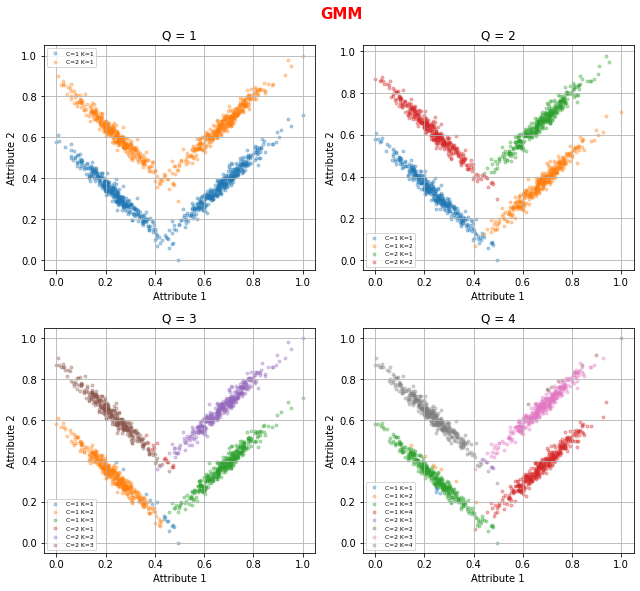

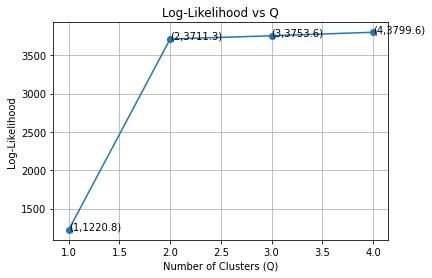

In [ ]:
#Data
C1 = pd.read_csv('class1.txt',header=None)
C1['class'] = 1
C2 = pd.read_csv('class2.txt',header=None)
C2['class'] = 2
Data = np.concatenate((C1,C2))
#Min-Max Normalization
Data[:,:2] = (Data[:,:2] - Data[:,:2].min(axis=0))/(Data[:,:2].max(axis=0) - Data[:,:2].min(axis=0))

#Bayes Classification on GMM
Q = [1,2,3,4];Log_Likelihood = []
a = 2;b = int(np.ceil(len(Q)/a))
fig,ax = plt.subplots(a,b,squeeze=False,figsize=(4.5*b,4*a))
fig.text(0.5,1,'GMM',color='Red',fontsize=15,fontweight='bold')
x,y = 0,0
for k in Q:
    log_likelihood = Bayes_Classifier(Data,Q=k,ax1=x,ax2=y)
    Log_Likelihood.append(log_likelihood)
    y+=1
    if y==b:x+=1;y=0
plt.tight_layout()
plt.show()

#Log-Likelihood vs Q
plt.plot(Q,Log_Likelihood,marker='o')
for i in range(len(Log_Likelihood)):
  a=round(Q[i],1)
  b=round(Log_Likelihood[i],1)
  txt = '(' + str(a) + ',' + str(b) + ')'
  plt.annotate(txt,(Q[i],Log_Likelihood[i]))
plt.title('Log-Likelihood vs Q')
plt.xlabel('Number of Clusters (Q)');plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()

# Kmeans

In [ ]:
#KMeans
def KMeans(Data,K,Class,x,y,itr=1e4,tol=1e-5,rep = 100):
    Distortion_out = 10**100
    #Repeating Algorithm and Choosing Cluster with Minimum Distortion
    for i in range(rep):
        iterate = itr
        #Choosing Cluster Mean points randomnly from Dataset
        KMean = np.random.permutation(Data)[:K]
        KMean_Prev = KMean*0
        #Computing KMeans for Clusters
        while(iterate and ((KMean - KMean_Prev)**2).sum()**0.5>tol):
            KMean_Prev = KMean
            Dist = np.zeros((Data.shape[0],K))
            #Computing Distance from Cluster Means
            for k in range(K):
              Dist[:,k] = ((Data - KMean[k])**2).sum(axis=1)

            # Expectation step
            # Estimate the assignment
            Cluster = Dist.argmin(axis=1)

            # Maximisation step
            # Reestmating the Cluster Means
            for k in range(K):
                if len(Data[Cluster==k]):
                  KMean[k] = Data[Cluster==k].mean(axis=0)
                else:
                  KMean[k] *= 0
            iterate-=1

        #Computing Distortion
        Distortion = 0
        for k in range(K):
            if len(Data[Cluster==k]):
              Distortion += sum(((Data[Cluster==k] - KMean[k])**2).sum(axis=1)**0.5)

        #Cluster With Minimum Distortion
        if Distortion<Distortion_out:
          Distortion_out, Cluster_out, KMean_out = Distortion, Cluster, KMean

    #Plot
    # Plot(Cluster_out, KMean_out, K,x,y)
    for k in range(K):
        ax[x][y].scatter(Data[Cluster_out==k][:,0],Data[Cluster_out==k][:,1],alpha=1/3,
                    marker='.',label ='C='+str(Class)+' K='+str(k+1))
    ax[x][y].scatter(KMean_out[:,0],KMean_out[:,1],
                    marker='*',s=25,label='CM '+str(Class),color='black')
    return KMean_out,Distortion_out

def Classifier(Data,K,ax1,ax2):
    print('*'*37,'K = ',K,'*'*37)
    #Test-Train Split
    np.random.shuffle(Data)
    f = 0.7
    train,test = Data[:int(f*Data.shape[0])],Data[int(f*Data.shape[0]):]

    C1 = train[train[:,-1]==1][:,:-1]
    C2 = train[train[:,-1]==2][:,:-1]

    KMean1,Distortion1 = KMeans(C1, K, 1,ax1,ax2) #K-Means on C1
    KMean2,Distortion2 = KMeans(C2, K, 2,ax1,ax2) #K-Means on C2
    Distortion = Distortion1+Distortion2          #Total Distortion

    ax[ax1][ax2].set_title('K = '+str(K))
    ax[ax1][ax2].legend(fontsize=6)
    ax[ax1][ax2].set_xlabel('Attribute 1')
    ax[ax1][ax2].set_ylabel('Attribute 2')
    ax[ax1][ax2].grid()

    y = test[:,-1]
    Prediction = y*0

    #Class assigned as the Class of Closest Cluster Center
    for i in range(len(test)):
      D1 = min(np.sqrt(((KMean1 - test[i][:-1])**2).sum(axis=1)))
      D2 = min(np.sqrt(((KMean2 - test[i][:-1])**2).sum(axis=1)))
      if D1<=D2:Prediction[i] = 1
      else:     Prediction[i] = 2

    d = Data.shape[-1] - 1
    Confusion_Matrix = np.zeros((d,d))
    #Confusion Matrix
    for og_class in range(1,3):
        for pred_class in range(1,3):
            Confusion_Matrix[og_class-1][pred_class-1] = sum(y[Prediction==pred_class]==og_class)

    Confusion_Matrix = np.int64(Confusion_Matrix)
    Accuracy = 0
    Precision= 0
    Recall   = 0
    F1_score = 0
    for i in range(2):
        Accuracy += Confusion_Matrix[i][i]
        if sum(Confusion_Matrix[i]):
            Precision+= Confusion_Matrix[i][i]/sum(Confusion_Matrix[i])*sum(Confusion_Matrix[:,i])
        if sum(Confusion_Matrix[:,i]):
            Recall+=Confusion_Matrix[i][i]/sum(Confusion_Matrix[:,i])*sum(Confusion_Matrix[:,i])
    if Confusion_Matrix.sum():
        Accuracy /=Confusion_Matrix.sum()
        Precision/=Confusion_Matrix.sum()
        Recall   /=Confusion_Matrix.sum()
    try:F1_score = 2*(Precision*Recall)/(Precision+Recall)
    except:F1_score = 0

    print('Confusion Matrix:\n',Confusion_Matrix)
    print('Accuracy:\t',np.around(Accuracy,4))
    print('Precision:\t',np.around(Precision,4))
    print('Recall:\t\t',np.around(Recall,4))
    print('F1-Score:\t',np.around(F1_score,4))
    print('\n')
    return Distortion


### Question 1

************************************* K =  1 *************************************
Confusion Matrix:
 [[591  14]
 [ 11 584]]
Accuracy:	 0.9792
Precision:	 0.9792
Recall:		 0.9792
F1-Score:	 0.9792


************************************* K =  2 *************************************
Confusion Matrix:
 [[617   2]
 [  5 576]]
Accuracy:	 0.9942
Precision:	 0.9942
Recall:		 0.9942
F1-Score:	 0.9942


************************************* K =  3 *************************************
Confusion Matrix:
 [[591   2]
 [  1 606]]
Accuracy:	 0.9975
Precision:	 0.9975
Recall:		 0.9975
F1-Score:	 0.9975


************************************* K =  4 *************************************
Confusion Matrix:
 [[599   2]
 [  3 596]]
Accuracy:	 0.9958
Precision:	 0.9958
Recall:		 0.9958
F1-Score:	 0.9958




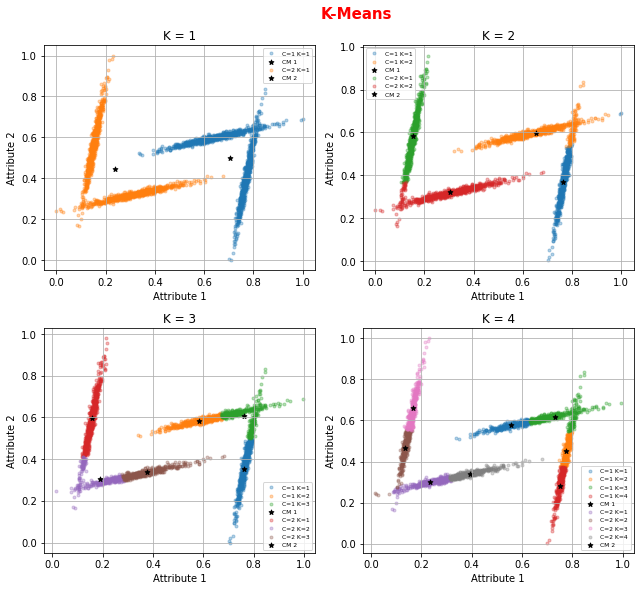

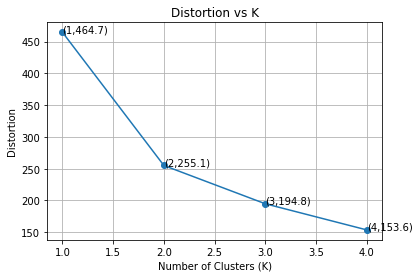

In [ ]:
#Data
C1 = pd.read_csv('Class1.txt',header=None)
C1['class'] = 1
C2 = pd.read_csv('Class2.txt',header=None)
C2['class'] = 2
Data = np.concatenate((C1,C2))
#Min-Max Normalization
Data[:,:2] = (Data[:,:2] - Data[:,:2].min(axis=0))/(Data[:,:2].max(axis=0) - Data[:,:2].min(axis=0))

#Classification on Kmeans
K = [1,2,3,4];Distortion = []
a = 2;b = int(np.ceil(len(K)/a))
fig,ax = plt.subplots(a,b,squeeze=False,figsize=(4.5*b,4*a))
fig.text(0.5,1,'K-Means',color='Red',fontsize=15,fontweight='bold')
x,y = 0,0
for k in K:
    distortion = Classifier(Data,K=k,ax1=x,ax2=y)
    Distortion.append(distortion)
    y+=1
    if y==b:x+=1;y=0
plt.tight_layout()
plt.show()

#Distortion vs K
plt.plot(K,Distortion,marker='o')
for i in range(len(Distortion)):
  a=round(K[i],1)
  b=round(Distortion[i],1)
  txt = '(' + str(a) + ',' + str(b) + ')'
  plt.annotate(txt,(K[i],Distortion[i]))
plt.title('Distortion vs K')
plt.xlabel('Number of Clusters (K)');plt.ylabel('Distortion')
plt.grid()
plt.show()

###Question 2

************************************* K =  1 *************************************
Confusion Matrix:
 [[280  25]
 [ 25 270]]
Accuracy:	 0.9167
Precision:	 0.9167
Recall:		 0.9167
F1-Score:	 0.9167


************************************* K =  2 *************************************
Confusion Matrix:
 [[273  27]
 [ 26 274]]
Accuracy:	 0.9117
Precision:	 0.9117
Recall:		 0.9117
F1-Score:	 0.9117


************************************* K =  3 *************************************
Confusion Matrix:
 [[308   7]
 [ 18 267]]
Accuracy:	 0.9583
Precision:	 0.9591
Recall:		 0.9583
F1-Score:	 0.9587


************************************* K =  4 *************************************
Confusion Matrix:
 [[295   3]
 [  6 296]]
Accuracy:	 0.985
Precision:	 0.985
Recall:		 0.985
F1-Score:	 0.985




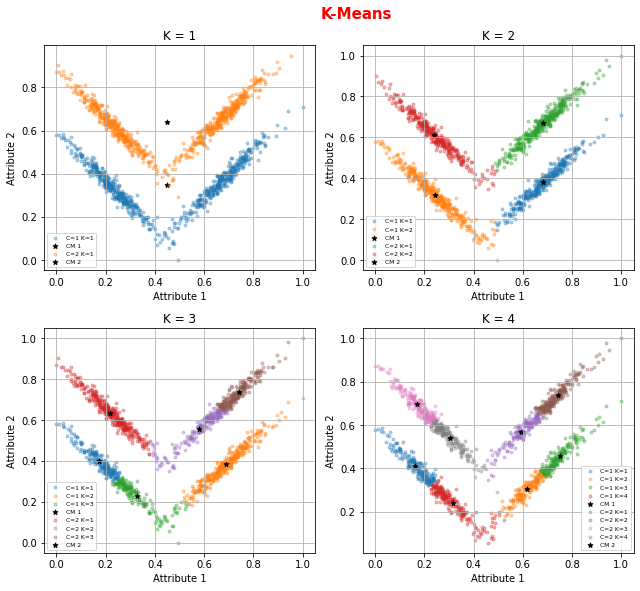

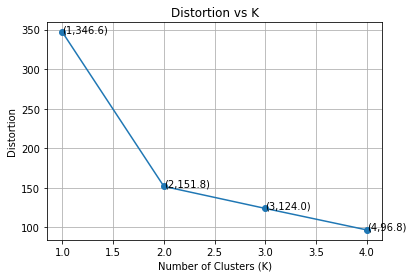

In [ ]:
#Data
C1 = pd.read_csv('class1.txt',header=None)
C1['class'] = 1
C2 = pd.read_csv('class2.txt',header=None)
C2['class'] = 2
Data = np.concatenate((C1,C2))
#Min-Max Normalization
Data[:,:2] = (Data[:,:2] - Data[:,:2].min(axis=0))/(Data[:,:2].max(axis=0) - Data[:,:2].min(axis=0))

#Classification on K-Means
K = [1,2,3,4];Distortion = []
a = 2;b = int(np.ceil(len(K)/a))
fig,ax = plt.subplots(a,b,squeeze=False,figsize=(4.5*b,4*a))
fig.text(0.5,1,'K-Means',color='Red',fontsize=15,fontweight='bold')
x,y = 0,0
for k in K:
    distortion = Classifier(Data,K=k,ax1=x,ax2=y)
    Distortion.append(distortion)
    y+=1
    if y==b:x+=1;y=0
plt.tight_layout()
plt.show()

#Distortion vs K
plt.plot(K,Distortion,marker='o')
for i in range(len(Distortion)):
  a=round(K[i],1)
  b=round(Distortion[i],1)
  txt = '(' + str(a) + ',' + str(b) + ')'
  plt.annotate(txt,(K[i],Distortion[i]))
plt.title('Distortion vs K')
plt.xlabel('Number of Clusters (K)');plt.ylabel('Distortion')
plt.grid()
plt.show()